# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [297]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from src.modules.game import Game
from src.helpers.q_learning import init_q, learn_policy, get_best_action, gen_episode, evaluate_policy
from src.pydantic_types import StateActionPair


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it"s equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [309]:
# Establish constants for training / evaluation / inference

###########################################################
################ training hyperparameters #################
###########################################################

n_episodes = 2_500_000 # number of rounds to train for.
gamma = .9 # decay hyperparameter. How much to discount sequential actions. Should be < 1.
lr = .0001 # learning rate
early_stop = False # whether we should early stop.
e = 10 # early stopping criterion. Number of "every" that have to pass without improvement.
every = 5_000
# will intermittently store best Q values through evaluation
backtrack = False # whether to revert back to optimal Q values after training completes.
method = "thompson" # sampling method during training exploration vs. exploitation

###########################################################
############### player module hyperparams #################
###########################################################

n_players = 1 # number of players
wagers = [1]*n_players # wagers per player "units"

moves = ["stay", "hit", "split", "double", "surrender"] # valid moves.


# These are all the possible rules the module allows for. There are default ones included in Game()
rules = {
    "dealerHitSoft17": True,
    "pushDealer22": False,
    "doubleAfterSplit": True,
    "hitAfterSplitAces": False,
    "reducedBlackjackPayout": False,
    "allowLateSurrender": True,
}


In [310]:
game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

In [311]:
# Generate random states according to a random policy

blackjack = Game(**game_hyperparams)

r_states = []

while len(r_states) < 250 :
    blackjack.init_round(wagers)
    blackjack.deal_init()
    s_s,_ = gen_episode(
        blackjack=blackjack,
        i_player=0,
        q=init_q(moves),
        epsilon=1, 
        method="epsilon"
    )
    if not s_s[0]: continue
    # randomly sample a state.
    ind_rand = np.random.choice(range(len(s_s[0])))
    s_a: StateActionPair = s_s[0][ind_rand]
    r_states.append((s_a.card1 if s_a.can_split else s_a.player_show, s_a.house_show, s_a.useable_ace, s_a.can_split))

### I"ll learn according to standard rules of play. I can evaluate by tweaking rules to observe house edge for both.

In [312]:
import asyncio

async def evaluate_game(q, n_rounds):
    blackjack = Game(**game_hyperparams)
    cummed = np.cumsum(evaluate_policy(blackjack, q, wagers, n_rounds)[0])[-1]
    return cummed/n_rounds

In [313]:
blackjack = Game(**game_hyperparams)

Q = init_q(moves)
eval = []
max_eval = []
eps_decay = .00001
min_eps = .1

n_rounds_evalute = 100
n_games_evaluate = 100

time_start = datetime.datetime.now()

r = 0
counter = 0
min_performance = -10

while r < n_episodes :
    
    blackjack.init_round(wagers)
    blackjack.deal_init()
    
    if not blackjack.house_blackjack : # If house blackjack, I don"t really care to learn. Nothing we can do.
        eps = -1
        if method == "epsilon" :
            eps = max(min_eps, np.exp(-eps_decay * r))
        learn_policy(
            blackjack=blackjack,
            q=Q,
            n_players=n_players,
            epsilon=eps,
            gamma=gamma,
            lr=lr,
            method=method
        )

    ## Evaluation
    ## Will entail 2 forms of evaluation.
    ##    1) Simulate gameplay, assess rewards for N games after M rounds.
    ##    2) Assess the randomly sampled states, check max Q value for each state. Ideally these increase through training.
    if not r % every :
        tasks = []
        for _ in range(n_games_evaluate):
            tasks.append(asyncio.create_task(evaluate_game(Q, n_rounds_evalute)))
        rewards = await asyncio.gather(*tasks)
        mean_reward = np.mean(rewards)
        eval.append(mean_reward)
        
        q_max = []
        for r_s in r_states :
            p,h,a,split = r_s
            if split :
                q_max.append(max(Q["can_split"][(p, h, a)].values()))
            else :
                q_max.append(max(Q["no_split"][(p, h, a)].values()))
        max_eval.append(np.mean(q_max))

        elapsed = datetime.datetime.now() - time_start
        print(f"Method {method} -- {r+1} of {n_episodes} -- Score : {mean_reward} -- Time elapsed : {elapsed} -- EPS : {eps}")

        if p < min_performance : 
            counter += 1
        else :
            counter = 0
            if backtrack :
                bestQ = Q.copy() # "backtracking". This will be used as optimal Q value dict. 
        min_performance = max(min_performance, p)

    if (early_stop) & (counter == e) :

        print("Early Stopping at Round {}.".format(r))
        break

    r += 1
if not backtrack : # without backtracking, just take final Q values.
    bestQ = Q.copy()

Method thompson -- 1 of 100000 -- Score : -0.44670000000000004 -- Time elapsed : 0:00:01.935895 -- EPS : -1
Method thompson -- 1001 of 100000 -- Score : -0.2302 -- Time elapsed : 0:00:04.029724 -- EPS : -1
Method thompson -- 2001 of 100000 -- Score : -0.1364 -- Time elapsed : 0:00:06.127166 -- EPS : -1
Method thompson -- 3001 of 100000 -- Score : -0.11739999999999999 -- Time elapsed : 0:00:08.231011 -- EPS : -1
Method thompson -- 4001 of 100000 -- Score : -0.13125 -- Time elapsed : 0:00:10.319069 -- EPS : -1
Method thompson -- 5001 of 100000 -- Score : -0.11325000000000002 -- Time elapsed : 0:00:12.484954 -- EPS : -1
Method thompson -- 6001 of 100000 -- Score : -0.0756 -- Time elapsed : 0:00:14.583696 -- EPS : -1
Method thompson -- 7001 of 100000 -- Score : -0.08585000000000002 -- Time elapsed : 0:00:16.678010 -- EPS : -1
Method thompson -- 8001 of 100000 -- Score : -0.092 -- Time elapsed : 0:00:18.789878 -- EPS : -1
Method thompson -- 9001 of 100000 -- Score : -0.0738 -- Time elapsed 

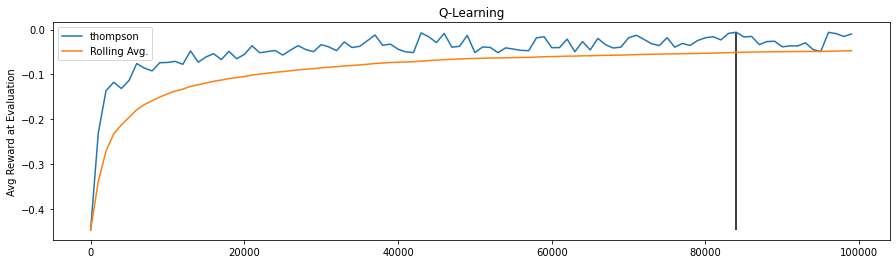

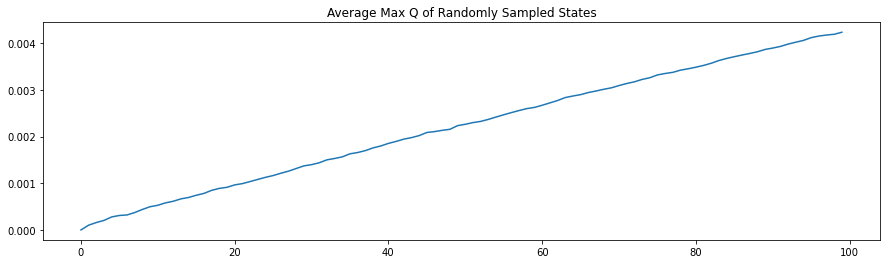

In [314]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(eval))*every,
    eval,
    label=method
)
plt.plot(
    np.arange(0,len(eval))*every,
    np.cumsum(eval) / np.arange(1,len(eval)+1),
    label="Rolling Avg."
)
plt.vlines(x=np.argmax(eval)*every,ymin=min(eval),ymax=max(eval),color="k")
plt.title("Q-Learning")
plt.ylabel("Avg Reward at Evaluation")
plt.legend()
plt.show()


plt.figure(figsize=(15,4))
plt.title("Average Max Q of Randomly Sampled States")
plt.plot(max_eval)
plt.show()

In [143]:
np.save("./models/Q",bestQ)
Qlearned = np.load("./models/Q.npy",allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

In [150]:
# I found online that this gameplay was optimal.

# I need to favor splitting, surrendering, doubling, if they are possible actions (ie, first move of the game).
# I"ll consider Stay/Hit as fallback moves, and denote them as 0.5
# Since the action space gets narrowed during training/inference, the value of 1 is ignored for double/surrender/split

acceptedQ = init_q(["stay","hit","split","double","insurance","surrender"])
for split,s_pairs in acceptedQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=="can_split" :
            if p == "A" :
                p = 11
            if p <= 3 :
                vals["hit"] = 0.5
                if h <= 7 :
                    vals["split"] = 1
            if p == 4 :
                vals["hit"] = 0.5
                if h in [5,6] :
                    vals["split"] = 1
            if p == 5 :
                vals["hit"] = 0.5
                if h <= 9 :
                    vals["double"] = 1
            if p == 6 :
                if h in [4,5,6] :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                if h <= 6 :
                    vals["split"] = 1
            if p == 7 :
                if h <= 6 :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                if h <= 7 :
                    vals["split"] = 1
            if p == 8 :
                if h <= 6 :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                vals["split"] = 1
            if p == 9 :
                vals["stay"] = 0.5
                if h in [2,3,4,5,6,8,9] :
                    vals["split"] = 1
            if p == 10 :
                vals["stay"] = 0.5
            if p == 11 :
                vals["split"] = 1
        else :
            if not a :
                if p <= 8 :
                    vals["hit"] = 0.5
                if p == 9 :
                    vals["hit"] = 0.5
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                if p == 10 :
                    vals["hit"] = 0.5
                    if h <= 9 :
                        vals["double"] = 1
                if p == 11 :
                    vals["hit"] = 0.5
                    vals["double"] = 1
                if p == 12 :
                    if 4 <= h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                if p in [13,14] :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                if p == 15 :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h == 10 :
                        vals["surrender"] = 1
                if p == 16 :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h >= 9 :
                        vals["surrender"] = 1
                if p >= 17 :
                    vals["stay"] = 0.5
            else :
                if p in [13,14] :
                    vals["hit"] = 0.5
                    if h in [5,6] :
                        vals["double"] = 1
                if p in [15,16] :
                    vals["hit"] = 0.5
                    if h in [4,5,6] :
                        vals["double"] = 1
                if p == 17 :
                    vals["hit"] = 0.5
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                if p == 18 :
                    if h <= 8 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h <= 6 :
                        vals["double"] = 1
                if p == 19 :
                    vals["stay"] = 0.5
                    if h == 6 :
                        vals["double"] = 1
                if p == 20 :
                    vals["stay"] = 0.5  

In [222]:
import asyncio

In [242]:
n_games = 2_500
n_rounds = 100

async def run_game(q, n_rounds):
    blackjack = Game(**game_hyperparams)
    cummed = np.cumsum(evaluate_policy(blackjack, q, wagers, n_rounds)[0])[-1]
    return cummed/n_rounds



print("Generating Random Rewards...")
randQ = init_q(["stay","hit","split","double","insurance","surrender"])
tasks = []
for _ in range(n_games):
    tasks.append(asyncio.create_task(run_game(randQ, n_rounds)))
random_rewards = await asyncio.gather(*tasks)

print("Generating Learned Rewards...")
tasks = []
for _ in range(n_games):
    tasks.append(asyncio.create_task(run_game(Qlearned, n_rounds)))
learned_rewards = await asyncio.gather(*tasks)
    
print("Generating Accepted Rewards... (found online to be optimal play)")
tasks = []
for _ in range(n_games):
    tasks.append(asyncio.create_task(run_game(acceptedQ, n_rounds)))
accepted_rewards = await asyncio.gather(*tasks)
    
print("Generating Meh Rewards...")
somewhat_smart_q = init_q(["stay","hit","split","double","insurance","surrender"])
for split,s_pairs in somewhat_smart_q.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=="can_split" :
            if p == "A" :
                p = 12
            else :
                p = p*2
        if p >= 17 :
            vals["stay"] = 1
        else :
            vals["hit"] = 1

tasks = []

for _ in range(n_games):
    tasks.append(asyncio.create_task(run_game(somewhat_smart_q, n_rounds)))

meh_rewards = await asyncio.gather(*tasks)
print("Done")

Generating Random Rewards...
Generating Learned Rewards...
Generating Accepted Rewards... (found online to be optimal play)
Generating Meh Rewards...
Done


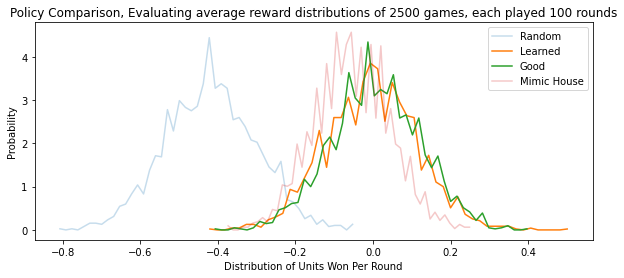

In [251]:
plt.figure(figsize=(10,4))
plt.title(f"Policy Comparison, Evaluating average reward distributions of {n_games} games, each played {n_rounds} rounds")

a,b = np.histogram(random_rewards,bins=50, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Random", alpha=.25)

a,b = np.histogram(learned_rewards,bins=50, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Learned")

a,b = np.histogram(accepted_rewards,bins=50, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Good")

a,b = np.histogram(meh_rewards,bins=50, density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])],a, label="Mimic House", alpha=.25)

plt.xlabel("Distribution of Units Won Per Round")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [247]:
print("We can observe the Expected Value of Blackjack following these policies:")
print("This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)\n")
print("Play Randomly:")
print(f"\t{np.mean(random_rewards):.4f} units net per round\n")
print("Mimicing the House:")
print(f"\t{np.mean(meh_rewards):.4f} units net per round\n")
print("Following Accepted Policy:")
print(f"\t{np.mean(accepted_rewards):.4f} units net per round\n")
print("Following Learned Policy:")
print(f"\t{np.mean(learned_rewards):.4f} units net per round\n")

We can observe the Expected Value of Blackjack following these policies:
This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)

Play Randomly:
	-0.4190 units net per round

Mimicing the House:
	-0.0551 units net per round

Following Accepted Policy:
	0.0070 units net per round

Following Learned Policy:
	-0.0036 units net per round



### While sampling helped in training Q values, it"s clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn"t even take card count into account**

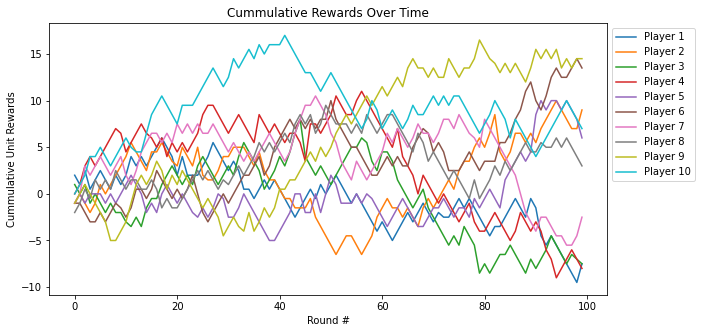

In [248]:
plt.figure(figsize=(10,5))

for i in range(10) :
    blackjack = Game(**game_hyperparams)
    try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
        r = np.cumsum(evaluate_policy(blackjack,Qlearned,wagers,n_rounds_evaluate)[0])
    except :
        r = np.cumsum(evaluate_policy(blackjack,bestQ,wagers,n_rounds_evaluate)[0])
    plt.plot(r,label="Player {}".format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title("Cummulative Rewards Over Time")
plt.xlabel("Round #")
plt.ylabel("Cummulative Unit Rewards")
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [173]:
blackjack = Game(**game_hyperparams)

blackjack.init_round(wagers=[1])
blackjack.deal_init()
player = blackjack.players[0] # only 1 player, so i"ll just extract that specific player module.
houseShow = blackjack.get_house_show(showValue=True)

print("Player Cards / Moves:")
while not player.is_done() :

    player_show, can_split, useable_ace, card1 = player.get_value()

    policy = player.get_valid_moves(houseShow)
    policy = [p for p in policy if p!="insurance"]
    if can_split :
        move = get_best_action(Qlearned["can_split"][(card1,houseShow,useable_ace)], policy, -1, "epsilon")
    else :
        move = get_best_action(Qlearned["no_split"][(player_show,houseShow,useable_ace)], policy, -1, "epsilon")
    print(player.cards, move)
    
    blackjack.step_player(player, move)

if move not in ["stay","surrender"] :
    print(player.cards)

blackjack.step_house()

print("\nHouse Cards / Moves:")
print(blackjack.house.cards)
print("\nResult:")
blackjack.get_results()

Player Cards / Moves:
[[7, 2]] hit
[[7, 2, 5]] hit
[[7, 2, 5, 3]] stay

House Cards / Moves:
[['J', 6, 'K']]

Result:


([['win']], [1])

## Evaluation

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$ and take action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$

In reality, I"ll use:

$$V_s = max(Q(s,a))$$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [699]:
Qlearned = np.load("./models/Q.npy",allow_pickle=True).item()

In [174]:
fill = np.empty((3,21+1,11+1),dtype="O")
value_det = np.zeros((3,21+1,11+1))

In [175]:
# Two ways to define value function
# 1. Deterministic. Pick best action
# 2. Random. Pick best action according to probability, which is normalized from possible q-values

for k,v in Qlearned["no_split"].items() :
    p,h,a = k
    fill[int(a),p,h] = max(v,key=v.get)[:2].title()
    value_det[int(a),p,h] = max(v.values()) # Deterministic    
for k,v in Qlearned["can_split"].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    fill[2,p,h] = max(v,key=v.get)[:2].title()
    value_det[2,p,h] = max(v.values()) # Deterministic    

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don"t learn transition probabilities in this model-free method, so we always take the best action in our environment

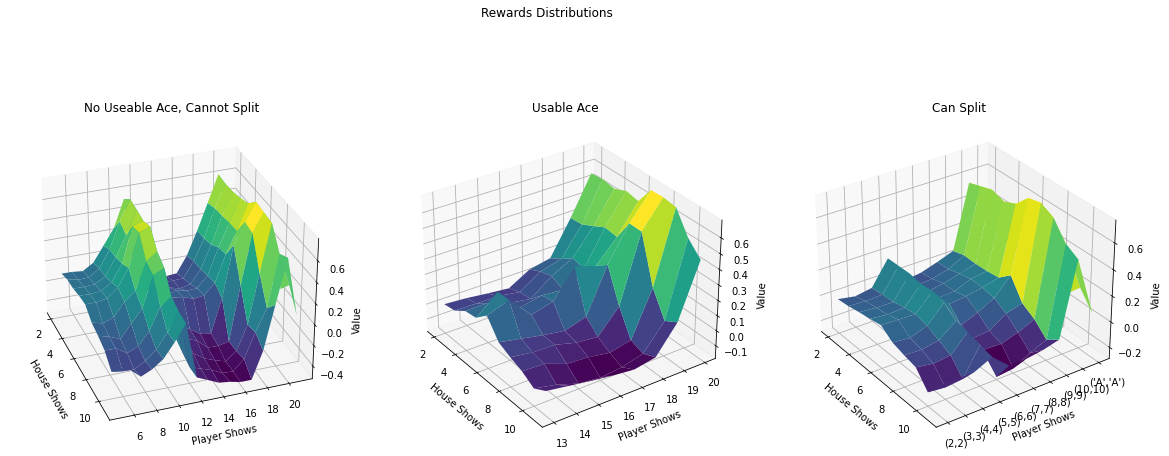

In [177]:
fig = plt.figure(figsize=(20,8))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

noAceMesh = value_det[0][5:,2:]
x,y = np.meshgrid(range(2,12),range(5,22))
ax.plot_surface(x, y, noAceMesh, rstride=1, cstride=1,cmap="viridis", edgecolor="none")
ax.view_init(azim=-20)
ax.set_xlabel("House Shows")
ax.set_ylabel("Player Shows")
ax.set_zlabel("Value")

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace")
usableAceMesh = value_det[1][13:21,2:]
x,y = np.meshgrid(range(2,12),range(13,21))

ax.plot_surface(x, y, usableAceMesh, rstride=1, cstride=1,cmap="viridis", edgecolor="none")
ax.view_init(azim=-35)
ax.set_xlabel("House Shows")
ax.set_ylabel("Player Shows")
ax.set_zlabel("Value")

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

canSplitMesh = value_det[2][2:12,2:]
x,y = np.meshgrid(range(2,12),range(2,12))
ticks = ["({},{})".format(p,p) if p < 11 else "('A','A')" for p in range(2,12)]
ax.set(yticks=range(2,12), yticklabels=ticks)
ax.plot_surface(x, y, canSplitMesh, rstride=1, cstride=1,cmap="viridis", edgecolor="none")
ax.view_init(azim=-35)
ax.set_xlabel("House Shows")
ax.set_ylabel("Player Shows")
ax.set_zlabel("Value")

plt.subplots_adjust(hspace=0, wspace=0.2)

plt.show()

In [178]:
colorMap = {"St":"blue","Hi":"green","Do":"red","Su":"grey","Sp":"yellow"}
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)].style.applymap(lambda x: "background-color: %s" % colorMap[x])
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Do
12,Hi,Hi,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [179]:
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)].style.applymap(lambda x: "background-color: %s" % colorMap[x])
usableAce

,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
18,St,Do,Do,St,Do,St,St,Hi,Hi,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [180]:
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ("A","A") for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: "background-color: %s" % colorMap[x])
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(4, 4)",Hi,Hi,Hi,Sp,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,Sp,Sp,St,St,Sp,Sp,Sp
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


## I"m curious about frequency of busting as the house, on certain card totals

In [181]:
blackjack.init_round(wagers=[1])
blackjack.deal_init()
player = blackjack.players[0] # only 1 player, so i"ll just extract that specific player module.
houseShow = blackjack.get_house_show(showValue=True)

In [183]:
results = {}
busts = {}
player_results = {"soft":{},"hard":{}}

blackjack = Game(verbose=False)

for _ in range(1_000_000) :

    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[0] # only 1 player, so i"ll just extract that specific player module.
    houseShow = blackjack.get_house_show(showValue=True)
    
    r_p = player._get_value_cards(player.cards[0])
    soft = r_p[1]
    if r_p[0] not in player_results["soft"] :
        player_results["soft"][r_p[0]] = {"n": 0, "rewards": 0}
        player_results["hard"][r_p[0]] = {"n": 0, "rewards": 0}

    if houseShow not in results :
        results[houseShow] = {"n": 0, "bust": 0, "17": 0, "18": 0, "19": 0, "20": 0,"21": 0}
    results[houseShow]["n"] += 1


    while not player.is_done() :

        playerShow,canSplit,useableAce,card1 = player.get_value()

        policy = player.get_valid_moves(houseShow)
        policy = [p for p in policy if p!="insurance"]
        if canSplit :
            move = get_best_action(Qlearned["can_split"][(card1,houseShow,useableAce)], policy, -1, "epsilon")
        else :
            move = get_best_action(Qlearned["no_split"][(playerShow,houseShow,useableAce)], policy, -1, "epsilon")

        blackjack.step_player(player,move)


    blackjack.step_house()
    
    total, _ = blackjack.house._get_value_cards(blackjack.house.cards[0])

    if total > 21 :
        results[houseShow]["bust"] += 1
        if total not in busts :
            busts[total] = 0
        busts[total] += 1
    if total <= 21 :
        results[houseShow][str(total)] += 1
        
    r_player = player.get_result(total,blackjack.house.cards)
    player_results["soft" if soft else "hard"][r_p[0]]["n"] += 1
    player_results["soft" if soft else "hard"][r_p[0]]["rewards"] += r_player[-1]
    
    

In [184]:
print("Average Player Rewards Given Card Total at Draw")
for i in range(4, 22) :
    print(f"Card Total: {i}")
    if player_results["soft"][i]["n"] > 0 :
        print(f"\tSoft: {player_results['soft'][i]['rewards']/player_results['soft'][i]['n']}")
    else :
        print("\tSoft: NONE")
    if player_results["hard"][i]["n"] > 0 :
        print(f"\tHard: {player_results['hard'][i]['rewards']/player_results['hard'][i]['n']}")
    else :
        print("\tHard: NONE")

Average Player Rewards Given Card Total at Draw
Card Total: 4
	Soft: NONE
	Hard: -0.23479036574487064
Card Total: 5
	Soft: NONE
	Hard: -0.22772029372496663
Card Total: 6
	Soft: NONE
	Hard: -0.26030604088158044
Card Total: 7
	Soft: NONE
	Hard: -0.21280189157236953
Card Total: 8
	Soft: NONE
	Hard: -0.1320978452364819
Card Total: 9
	Soft: NONE
	Hard: 0.005063713761059485
Card Total: 10
	Soft: NONE
	Hard: 0.21184888931720716
Card Total: 11
	Soft: NONE
	Hard: 0.28719898605830163
Card Total: 12
	Soft: 0.4340668861549125
	Hard: -0.31078355139344355
Card Total: 13
	Soft: -0.030341023069207624
	Hard: -0.33477567201701797
Card Total: 14
	Soft: -0.04888507718696398
	Hard: -0.36895489005344534
Card Total: 15
	Soft: -0.08252106393523873
	Hard: -0.3853141559424678
Card Total: 16
	Soft: -0.09852746525479815
	Hard: -0.380886023613004
Card Total: 17
	Soft: -0.05655010875020913
	Hard: -0.2825907172995781
Card Total: 18
	Soft: 0.029080517734072952
	Hard: -0.02577085852478839
Card Total: 19
	Soft: 0.27274

In [185]:
print("Probability of House Having a Value on Bust")
for i in range(22,27) :
    print(f"Total {i}: {100*busts[i]/sum(busts.values())}%")

Probability of House Having a Value on Bust
Total 22: 25.723919842060205%
Total 23: 23.014483638206055%
Total 24: 20.091199748414486%
Total 25: 17.16162622080123%
Total 26: 14.008770550518022%


In [186]:
print("Probability of House Result")
out = []
for i in range(2,12) :
    inter = {}
    inter["Card Show"] = i
    for j in range(17,22) :
        inter[f"% {j}"] = 100*results[i][str(j)]/results[i]["n"]
    inter["% Bust"] = 100*results[i]["bust"]/results[i]["n"]
    out.append(inter)
              
pd.DataFrame(out)

Probability of House Result


,Card Show,% 17,% 18,% 19,% 20,% 21,% Bust
0,2,12.990531,13.626122,13.174175,12.702692,11.996770,35.509710
1,3,12.758647,13.248919,12.436947,12.115246,11.642989,37.797251
2,4,12.158126,12.650321,12.198384,11.751643,11.162048,40.079478
3,5,11.757579,12.239607,11.839654,11.321148,10.646309,42.195703
4,6,11.383963,11.468462,11.614061,11.126566,10.528574,43.878373
5,7,36.514825,13.809994,7.967154,7.956760,7.340904,26.410363
6,8,12.780839,35.856159,12.957970,7.065734,7.021451,24.317847
7,9,11.989972,11.782371,35.293580,12.151876,6.067451,22.714750
8,10,11.143448,11.205557,11.169137,34.011108,11.225392,21.245358
9,11,5.548048,14.466504,14.172860,14.198846,37.563016,14.050725


## Next, I want to incorporate "card count" into the model. This makes the space too large. The solution to this is approximating the Q learning function, through deep learning methods.